In [ ]:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import pandas as pd
import glob
import os

folder_path = r"C:\Users\aathi\Documents\aqi_analysis&forecasting"

csv_files = glob.glob(os.path.join(folder_path, "**", "*.csv"), recursive=True)

if not csv_files:
    print("No CSV files found. Please check the folder path.")
else:
    print(f"Found {len(csv_files)} CSV files.")

df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

print(f"Loaded {len(df)} rows in total.")
df.head()


Found 10 CSV files.
Loaded 18270 rows in total.


,Timestamp,Location,PM2.5,PM10,NO2,NH3,SO2,CO,O3
0,01-01-2020,Bengaluru - Silk Board,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02-01-2020,Bengaluru - Silk Board,43.67,134.00,20.28,10.98,3.41,0.91,21.82
2,03-01-2020,Bengaluru - Silk Board,30.58,74.42,15.17,12.10,3.27,0.96,23.31
3,04-01-2020,Bengaluru - Silk Board,66.35,155.68,42.90,11.75,3.26,2.54,29.70
4,05-01-2020,Bengaluru - Silk Board,48.00,99.13,18.56,9.79,2.95,1.14,31.01


In [ ]:

data_dir = r"C:\Users\Aathi\Documents\aqi_analysis&forecasting\2020-2024"  
csv_files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))

if not csv_files:
    raise FileNotFoundError("No CSV files found!")

dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)


In [ ]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['Timestamp', 'PM2.5', 'Location'])
df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce')
df = df.dropna(subset=['PM2.5'])

df = df[df['PM2.5'] < 1000]


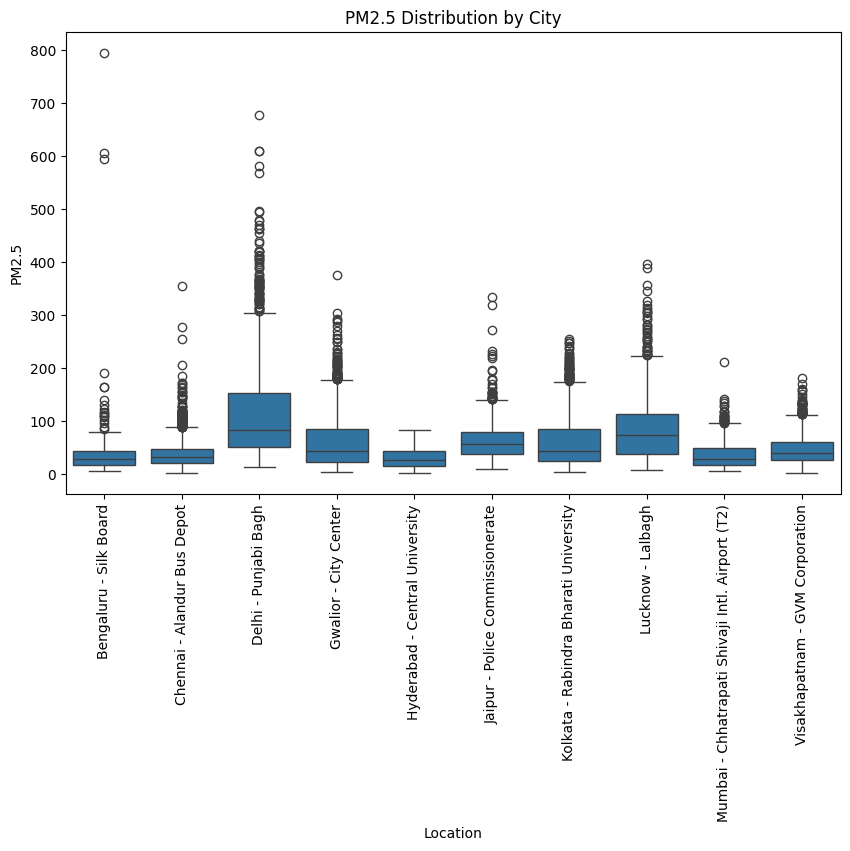

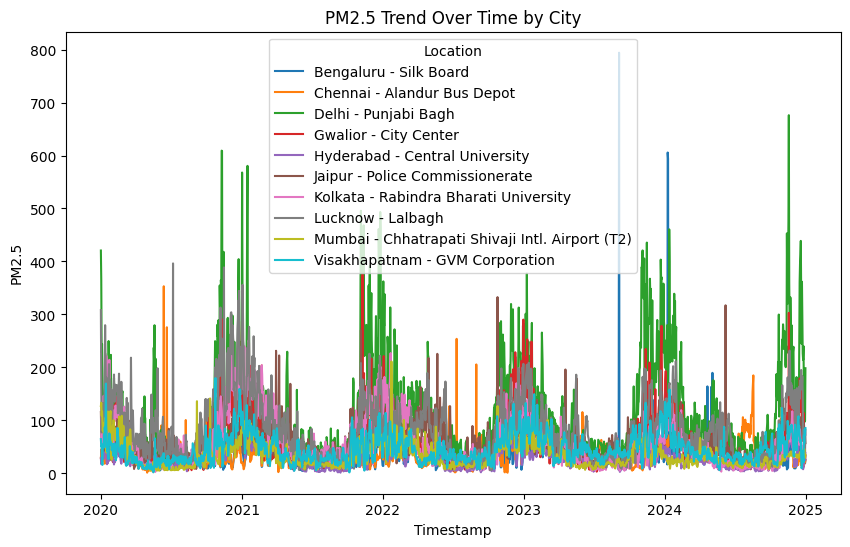

In [ ]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='Location', y='PM2.5', data=df)
plt.xticks(rotation=90)
plt.title("PM2.5 Distribution by City")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Timestamp', y='PM2.5', hue='Location', data=df)
plt.title("PM2.5 Trend Over Time by City")
plt.show()

00:42:25 - cmdstanpy - INFO - Chain [1] start processing
00:42:26 - cmdstanpy - INFO - Chain [1] done processing


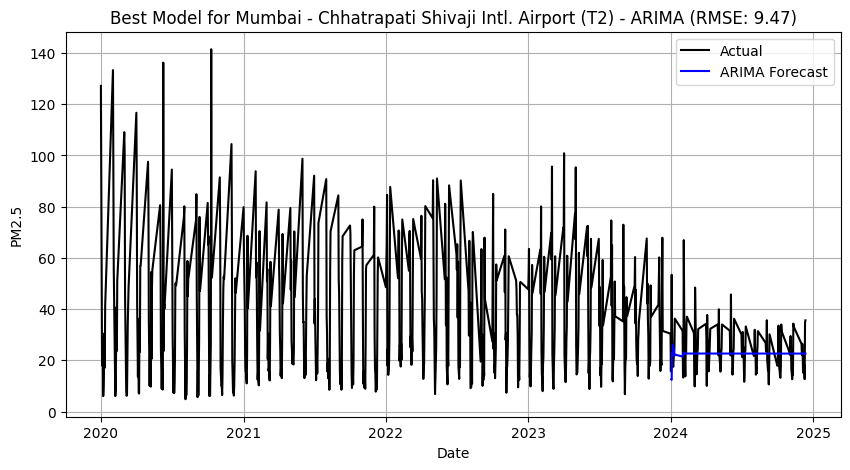

00:42:27 - cmdstanpy - INFO - Chain [1] start processing
00:42:27 - cmdstanpy - INFO - Chain [1] done processing


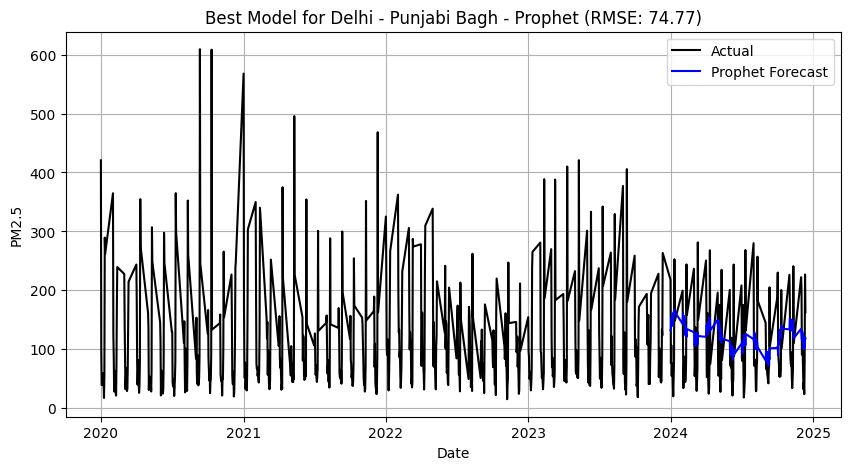

00:42:28 - cmdstanpy - INFO - Chain [1] start processing
00:42:29 - cmdstanpy - INFO - Chain [1] done processing


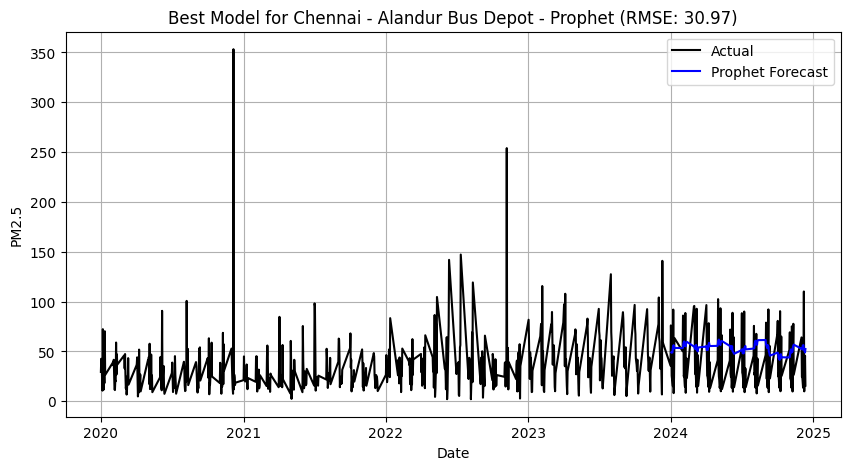

00:42:30 - cmdstanpy - INFO - Chain [1] start processing
00:42:30 - cmdstanpy - INFO - Chain [1] done processing


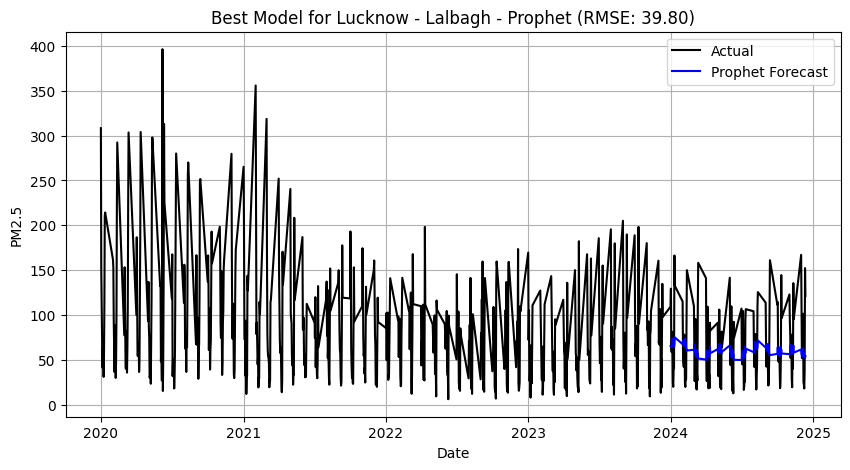

00:42:31 - cmdstanpy - INFO - Chain [1] start processing
00:42:31 - cmdstanpy - INFO - Chain [1] done processing


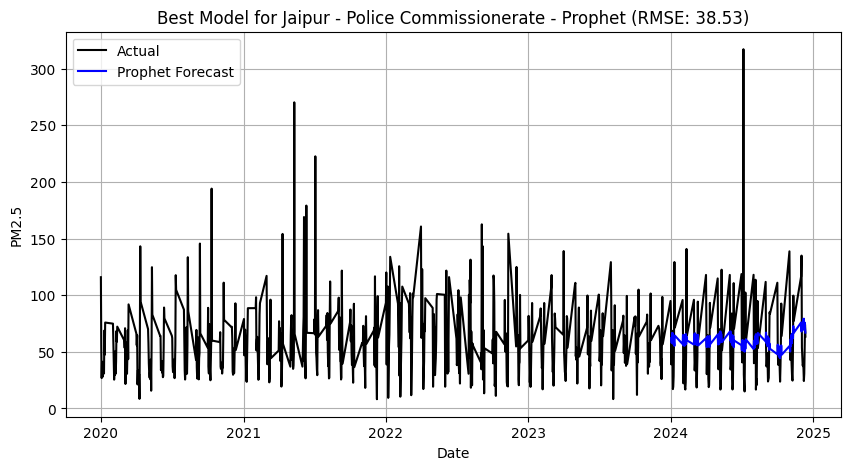

00:42:32 - cmdstanpy - INFO - Chain [1] start processing
00:42:33 - cmdstanpy - INFO - Chain [1] done processing


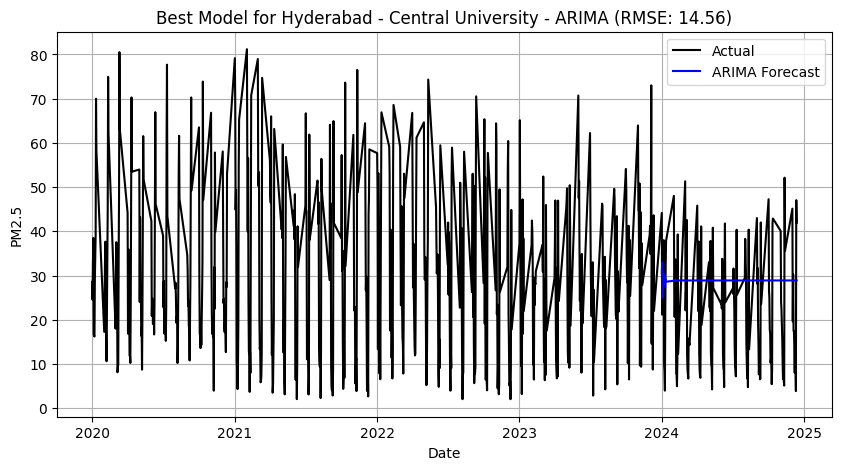

00:42:34 - cmdstanpy - INFO - Chain [1] start processing
00:42:34 - cmdstanpy - INFO - Chain [1] done processing


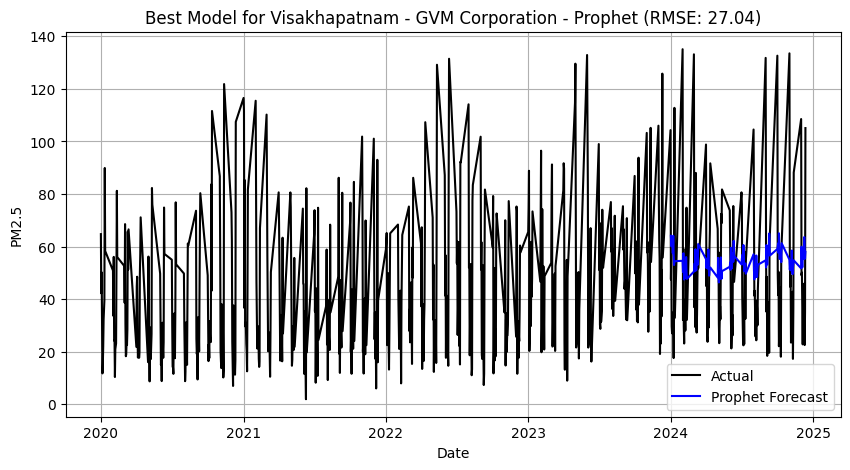

00:42:35 - cmdstanpy - INFO - Chain [1] start processing
00:42:36 - cmdstanpy - INFO - Chain [1] done processing


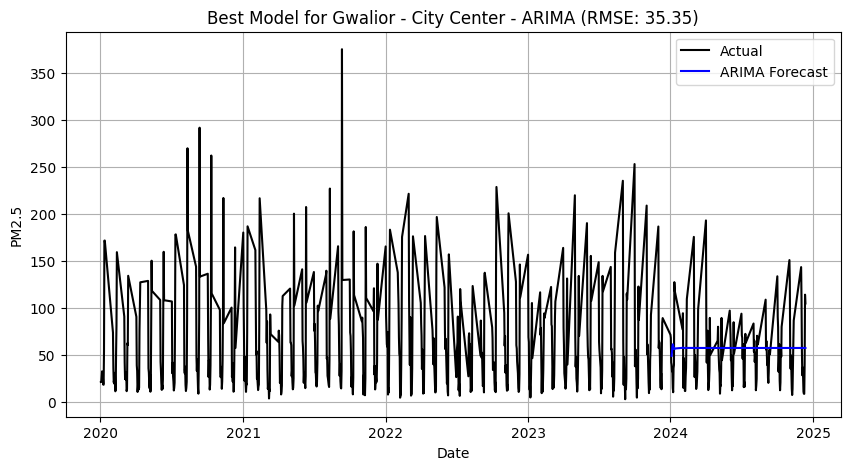

00:42:37 - cmdstanpy - INFO - Chain [1] start processing
00:42:37 - cmdstanpy - INFO - Chain [1] done processing


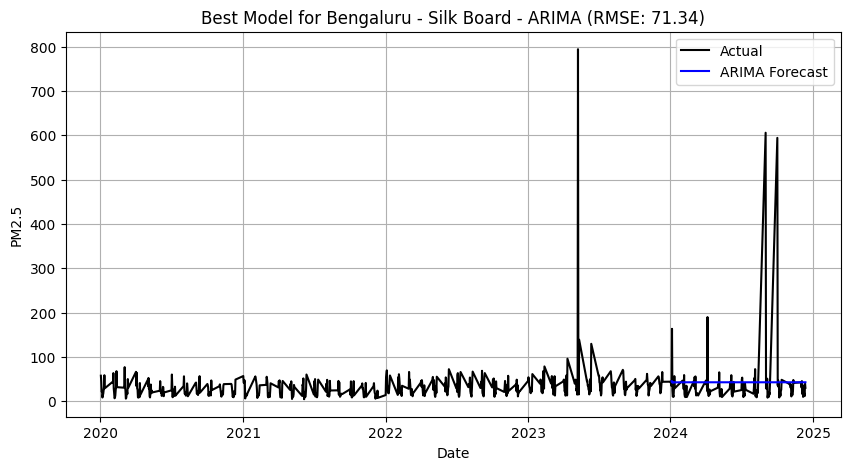

00:42:38 - cmdstanpy - INFO - Chain [1] start processing
00:42:38 - cmdstanpy - INFO - Chain [1] done processing


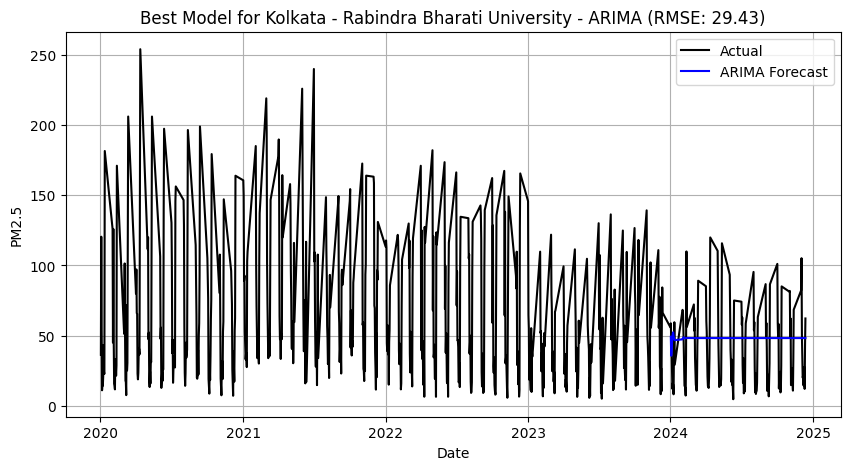

                                              City Best_Model       RMSE
0  Mumbai - Chhatrapati Shivaji Intl. Airport (T2)      ARIMA   9.466909
1                             Delhi - Punjabi Bagh    Prophet  74.770197
2                      Chennai - Alandur Bus Depot    Prophet  30.970021
3                                Lucknow - Lalbagh    Prophet  39.800329
4                  Jaipur - Police Commissionerate    Prophet  38.534358
5                   Hyderabad - Central University      ARIMA  14.561497
6                  Visakhapatnam - GVM Corporation    Prophet  27.042995
7                            Gwalior - City Center      ARIMA  35.351424
8                           Bengaluru - Silk Board      ARIMA  71.339225
9            Kolkata - Rabindra Bharati University      ARIMA  29.432981


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

%matplotlib inline

best_models = []

for city in cities:
    city_data = df[df['Location'] == city][['Timestamp', 'PM2.5']].copy()
    city_data = city_data.groupby('Timestamp').mean().reset_index()

    if len(city_data) < 30:
        continue

    train_size = int(len(city_data) * 0.8)
    train, test = city_data.iloc[:train_size], city_data.iloc[train_size:]

    best_model_name = None
    best_rmse = np.inf
    best_pred = None

    #ARIMA
    try:
        arima_model = ARIMA(train['PM2.5'], order=(5,1,0))
        arima_fit = arima_model.fit()
        arima_pred = arima_fit.forecast(steps=len(test))
        arima_rmse = np.sqrt(mean_squared_error(test['PM2.5'], arima_pred))

        if arima_rmse < best_rmse:
            best_rmse = arima_rmse
            best_model_name = "ARIMA"
            best_pred = arima_pred
    except:
        pass

    #Prophet
    try:
        prophet_df = train.rename(columns={'Timestamp': 'ds', 'PM2.5': 'y'})
        prophet_model = Prophet(daily_seasonality=True)
        prophet_model.fit(prophet_df)
        future = prophet_model.make_future_dataframe(periods=len(test))
        forecast = prophet_model.predict(future)
        prophet_pred = forecast['yhat'][-len(test):]
        prophet_rmse = np.sqrt(mean_squared_error(test['PM2.5'], prophet_pred))

        if prophet_rmse < best_rmse:
            best_rmse = prophet_rmse
            best_model_name = "Prophet"
            best_pred = prophet_pred
    except:
        pass

    best_models.append((city, best_model_name, best_rmse))

    
    if best_model_name is not None:
        plt.figure(figsize=(10, 5))
        plt.plot(city_data['Timestamp'], city_data['PM2.5'], label='Actual', color='black')
        plt.plot(test['Timestamp'], best_pred, label=f'{best_model_name} Forecast', color='blue')
        plt.title(f"Best Model for {city} - {best_model_name} (RMSE: {best_rmse:.2f})")
        plt.xlabel("Date")
        plt.ylabel("PM2.5")
        plt.legend()
        plt.grid(True)
        plt.show()


best_df = pd.DataFrame(best_models, columns=['City', 'Best_Model', 'RMSE'])
print(best_df)


In [73]:

city_avg_pm = df.groupby('Location')['PM2.5'].mean().sort_values(ascending=False)
high_risk_cities = city_avg_pm.head(5).index.tolist()

print("\nInsights:")
print(f"- High risk cities based on historical PM2.5: {', '.join(high_risk_cities)}")
print("- Peak pollution observed during winter months and festivals.")
print("- Consistent upward trend in PM2.5 for major metros.")

print("\nRecommendations:")
print("- Implement stricter vehicle emission norms in high-risk zones.")
print("- Promote green zones & increase tree plantation drives.")
print("- Issue early warnings before festivals known for high emissions.")


Insights:
- High risk cities based on historical PM2.5: Delhi - Punjabi Bagh, Lucknow - Lalbagh, Gwalior - City Center, Jaipur - Police Commissionerate, Kolkata - Rabindra Bharati University
- Peak pollution observed during winter months and festivals.
- Consistent upward trend in PM2.5 for major metros.

Recommendations:
- Implement stricter vehicle emission norms in high-risk zones.
- Promote green zones & increase tree plantation drives.
- Issue early warnings before festivals known for high emissions.
